## Installing dependencies

In [0]:
!pip install langchain langchain_core
!pip install -U langchain-tavily
!pip install -U langgraph langsmith
!pip install -U langchain-openai
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install langgraph sqlalchemy
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:729)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:447)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:447)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

In [0]:
dbutils.library.restartPython()

### Import required libraries

In [0]:
import os
import json 
from datetime import date, datetime

from typing import Annotated, TypedDict, List

from langgraph.graph import StateGraph, END, START

from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.messages import BaseMessage

from langchain_tavily import TavilySearch

from langchain.chat_models import init_chat_model

from langgraph.prebuilt import ToolNode, tools_condition

In [0]:
os.environ['OPEN_WEATHER_API_LAT_LON_KEY']        = '8541d82ddd601d7120aeb26457d68a4f'
os.environ["TAVILY_API_KEY"]                      = "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"
os.environ["AZURE_OPENAI_API_KEY"]                = "ca9d9c7ca2934c2aadb9c05910be7330"
os.environ['FOURSQUARE_API_KEY']                  = 'fsq3z40s57BNzokRVYCQzN7GieGlwJKOuA+uT8PFDTxIFto='
os.environ['WEATHER_FORCAST_API_KEY']             = 'bb7c7fcb9a984c9b9cd101743252105'

## Initializing the PlannerState

In [0]:
class DestinationEntry(TypedDict):
    destination_name: str
    destination_duration: str   

class PlannerState(TypedDict):
  user_name : str
  messages: Annotated[list, add_messages]
  destinations: List[DestinationEntry]
  interests: List[str]
  total_duration: int
  budget_tier: str
  start_date: str
  end_date: str
  packing_suggestions: List[str]
  itinerary: []
  month_of_visit: str
  purpose: str
  lats: List[str]
  lons: List[str]
  weather_data: []


graph_builder = StateGraph(PlannerState)

##  Creating SQLite Db and their read and write functions

In [0]:
import sqlite3
import json

# Initialize the SQLite database and create the table if it doesn't exist
def initialize_database(db_path='memory.db'):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS memories (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_name TEXT,
            destinations TEXT,
            interests TEXT,
            total_duration INTEGER,
            start_date TEXT,
            end_date TEXT,
            month_of_visit TEXT,
            budget_tier TEXT,
            purpose TEXT,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    ''')
    conn.commit()
    conn.close()

initialize_database()

# Helper function: save the memory in the db- 
def save_memory(user_id, destinations, interests, total_duration, start_date, end_date, month_of_visit, budget_tier, purpose, db_path='memory.db'):

  initialize_database()
  conn = sqlite3.connect(db_path)
  cursor = conn.cursor()

  cursor.execute('''
      INSERT INTO memories (
          user_name,
          destinations,
          interests,
          total_duration,
          start_date,
          end_date,
          month_of_visit,
          budget_tier,
          purpose
          
      ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
  ''', (
      user_id,
      json.dumps(destinations),
      json.dumps(interests),
      total_duration,
      start_date,
      end_date,
      month_of_visit,
      budget_tier,
      purpose
  ))
  conn.commit()
  conn.close()

# Helper function: loads/retrives the memory from the db
def load_memories(user_name, db_path='memory.db'):
  conn = sqlite3.connect(db_path)
  cursor = conn.cursor()
  cursor.execute('SELECT * FROM memories WHERE user_name = ?', (user_name,))
  rows = cursor.fetchall()
  conn.close()
  return rows

# NODE FUNCTION: saves the memory of the user from db
def node_save_details(state:PlannerState):
  user_id         = state['user_name']
  destinations    = state['destinations']
  interests       = state['interests']
  total_duration  = state['total_duration']
  start_date      = state['start_date']
  month_of_visit  = state['month_of_visit']
  budget_tier     = state['budget_tier']
  purpose         = state['purpose']
  end_date        = state['end_date']

  save_memory(user_id, destinations, interests, total_duration, start_date, end_date, month_of_visit, budget_tier, purpose)
  return state

# NODE FUNCTION: fetched the memory of the user from db
def node_fetch_details(state:PlannerState):
  user_name = str(input("Enter your user_name: "))
  user_id = user_name
  rows = load_memories(user_name)
  return{
    **state,
    "user_name" : user_name
  }


## Creating Graph for agent

### Tavily tool for searching

In [0]:
tool = TavilySearch(max_results = 2)
tools = [tool]
tool_node = ToolNode(tools=[tool])

#create route_tool to direct the flow
def route_tool(state:PlannerState):
    messages = state["messages"]
    recent_to_old = messages[::-1]
    for last_msg in recent_to_old:
      if isinstance(last_msg, AIMessage) and hasattr(last_msg, "tool_calls") and len(last_msg.tool_calls) > 0:
          return "tools"
    return "get_lat_long"

#create node to run/call the tool : langchain docs reference
def tavilo_search(state):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

    

### LLM setup

In [0]:

os.environ["AZURE_OPENAI_ENDPOINT"] = "https://openai-ds-dev-uswest.openai.azure.com/openai/deployments/gpt-4o-2/chat/completions?api-version=2025-01-01-preview"
os.environ["OPENAI_API_VERSION"] = "2025-03-01-preview"

llm1 = init_chat_model(
    "azure_openai:gpt-4o-2",
    azure_deployment=os.environ["AZURE_OPENAI_ENDPOINT"]
)

llm_with_tools = llm1.bind_tools(tools)

### Nodes and their Helper functions

In [0]:
# helper function: format the past message so that they can interpreted by LLM
def create_format(past_memories):
  # if past data does exist
  if len(past_memories) > 0:
    # unpack memory
    (_, user_id, dest_json, interests_json, total_duration, start_date,
     end_date, month_of_visit, budget_tier, purpose, timestamp) = past_memories
  # parse JSON fields
  try:
      destinations = json.loads(dest_json)
  except:
      destinations = []
  try:
      interests = json.loads(interests_json)
  except:
      interests = []
  # create final format the destinations
  formatted_dests = "\n".join(
      f"- {d['destination_name']} for {d['destination_duration']} days"
      for d in destinations
  )
  return formatted_dests

In [0]:
# NODE FUNCTION: understands the user query and extracts the required details for state
def understand_query(state: PlannerState):
  prompt_time = datetime.now()

  #get the previous information of the user if it exists
  past_memories = load_memories(state["user_name"])
  format_prev_details = ""
  if len(past_memories) > 0: 
    format_prev_details = create_format(past_memories[-1])

  #prompting for extracting required fields
  output_format = '''
  e.g: 
  ```json
    {
      "destinations":[{
				"destination_name": “name_of_destination”,
				“destination_duration”: “duration_of_destination”
				 }],
      "interests": ["...", "...."],
      "total_duration": "...",
      "budget_tier": "...",
      "start_date": "...",
      "end_date": "...",
      "month_of_visit": "...",
      "purpose": "..."
    }
  ``` '''
  main_prompt = f'''
  You are given a user query. Your task is to understand the query and then extract useful information from the query. The output should be a JSON object. The fields that need to be extracted become the keys in the JSON object. The keys are: destinations, interests, total_duration, budget_tier, start_date, end_date, month_of_visit and purpose.

  The output should follow a strict JSON format, with proper and correct formatting. eg: {output_format}
  
  For destinations there could be either a single value or multiple values in the user query add the destinations in “destinations” key as a list of dictionary with keys: “destination_name” and “destination_duration”. “destination_key” should have value as the name of the destination the user is visiting. “destination_duration” is the duration of their stay in the corresponding destination. If no explicit value for the destination_duration is provided, then take the default value as 3 . For multiple values, the “destinations ” key would contain multiple dictionaries with the keys: “destination_name” and “destination_duration”. If there is no value present for the destinations, then extract the destinations from the previous interaction, details: {format_prev_details}.

  For interests  there could either be a single value or multiple values in the user query. Identify the respective values for both destinations and interests then add them as a list of strings to their corresponding keys. If there is no value present for the interests, then extract the destinations from the previous interaction, details: {format_prev_details}.

  For field “budget_tier”, provide a budget rating from 1 to 4, 1 being the econoy and lowest and 4 being complete luxury. The values can only be: 1,2,3,4.Classify the budget in the user query amonth 1,2,3,4. eg: Moderate could be 3 or Budget-friendly could be 2, Luxury could be 4 and so on. If no value is present in the user-query, then the default value should be 3.

  For field “purpose” if no value is present in the user-query, then the default value should be "Moderate".

  The “total_duration” key represents the total duration of the trip. If a value for the total duration of the trip is provided then add that to “total_duration” key. Otherwise calculate the total_duration through “destination_duration” for the  destinations provided in the user-query.

  If any fields like  total_duration, end_date, start_date or next month are not present then try to derive them based on the user query, present fields and the date and timing of the execution. Ensure that duration values are numerical, end_date and start_date are of type datetime.

  “start_date” represents the starting date of the traveller. If no start date is provided in the user_query then by default take the next date from the current date. If “only the moth_of_visit” is provided then, take the first date of that month by default as the start_date.

  “end_date”, if no end_date of the trip is provided then calculate it based on the “total_duration” of the trip.

  These are the details of the user from previous interaction: {format_prev_details}. If any fields from: "desitnations", "interests", "budget_tier", "start_date", "end_date", "month_of_visit", "purpose" were not present in the current user_query only then try to derive from this interaction.
  '''
  date_info = f''' Consider current date and time to be {prompt_time}.'''

  # Invoke via the same llm_with_tools so you get back an AIMessage
  human = HumanMessage(content=main_prompt+date_info)
  # response: AIMessage = llm_with_tools.invoke(state["messages"] + [human])
  response: AIMessage = llm1.invoke(state["messages"] + [human])
  query_details = response.content.strip("```json").strip("```").strip()
  json_query_details = json.loads(query_details)
  
  #build the destinations for state
  all_dests = json_query_details.get("destinations", [])
  dests: List[DestinationEntry] = []

  for entry in all_dests:
    name = entry.get("destination_name", "")
    days = entry.get("destination_duration") or 3
    dests.append({
      "destination_name": name,
      "destination_duration": int(days)
    })

  return {
    **state,
      "destinations":   dests,
      "interests":     json_query_details.get("interests", ""),
      "total_duration": int(json_query_details.get("total_duration","")),
      "budget_tier":   json_query_details.get("budget_tier", ""),
      "start_date":    str(json_query_details.get("start_date","")),
      "end_date":      str(json_query_details.get("end_date","")),
      "month_of_visit": json_query_details.get("month_of_visit",""),
      "purpose":       json_query_details.get("purpose",""),
      "messages":      state["messages"] + [response], #preserve the list
  }


In [0]:
import requests

# API function: Uses API from OpenWeather API to fetch the latitude and longitude for each destination
def call_url_for_lat_long(destination):
  #OpenWeather API 
  url = f'http://api.openweathermap.org/geo/1.0/direct?q={destination}&limit=1&appid={os.environ["OPEN_WEATHER_API_LAT_LON_KEY"]}'

  geo_response = requests.get(url)
  #extract latitude and longitude
  lat_geo = str(geo_response.json()[0]['lat'])
  long_geo = str(geo_response.json()[0]['lon'])
  return lat_geo, long_geo

# NODE FUNCTION: fetches the latitude and longitude for each destination
def get_lat_long(state:PlannerState):
  lats: List[str] = []
  lons: List[str] = []

  for dest in state["destinations"]:
    destination = dest["destination_name"]
    lat_geo, long_geo = call_url_for_lat_long(destination)
    lats.append(lat_geo)
    lons.append(long_geo)
  return{
    **state,
    "lats" : lats,
    "lons" : lons
  }

In [0]:
# Helper function: identifies the required category based in interest and purpose and returns the required code
def build_categorey_param(interests,purpose):
  categories = {
    "Arts and Entertainment": "4d4b7104d754a06370d81259",
    "Community and Government": "63be6904847c3692a84b9b9a",    
    "Dining and Drinking": "63be6904847c3692a84b9bb5", 
    "Event": "4d4b7105d754a06373d81259",
    "Health and Medicine" : "63be6904847c3692a84b9bb9",
    "Landmarks and Outdoors" : "4d4b7105d754a06377d81259", 
    "Retail" : "4d4b7105d754a06378d81259",
    "Sports and Recreation": "4f4528bc4b90abdf24c9de85",
    "Travel and Transportation" : "4d4b7105d754a06379d81259"
  }
  output_format = ''' ```json{
    "categories": "4d4b7104d754a06370d81259,4d4b7105d754a06375d81259"
  }``` '''
  
  purpose_prompt = f'''You are given a purpose and interests of a user for a trip, interests: {interests}, purpose: {purpose}. Based on purpose and interests of the user, identify the suitable categories (can be multiple or single) for them from {categories}. This category map contains the category name and its corresponding codes. Once identified suitable categories for  [interests: {interests}, purpose: {purpose}], return the corresponding codes for all the **unique** catgories identified. If nothing from the purpose and interests can be classified in the categories, return the codes for "Landmarks and Outdoors","Dining and Drinking" and "Arts and Entertainment" as a single string.  
  The result should be a a JSON Object with key "categories" and value should be a single string containing the categories codes which are comma separated. 
  example for format: {output_format}
  Ensure the ouput format is correct and valid string and the codes are from unique categories identified.'''
    
  ans = llm1.invoke(purpose_prompt)
  categories_dict = ans.content.strip("```json").strip("```").strip()
  categories_map = json.loads(categories_dict)
  return categories_map["categories"]
  
    
# API function: Uses Places API from Foursquare 
def get_places(ll_s, categories, max_price, min_price):
  url = f"https://api.foursquare.com/v3/places/search?ll={ll_s}&categories={categories}&min_price={min_price}&max_price={max_price}&limit=50"
  headers = {
    "accept":'application/json',
    "Authorization": "fsq3z40s57BNzokRVYCQzN7GieGlwJKOuA+uT8PFDTxIFto="
  }
  places_response = requests.get(url, headers=headers)
  data = places_response.json()

  places = [] #saves a dict for (category, adress, name) for each place
  for item in data.get("results", []):
    category = item["categories"][0]["name"] if item.get("categories") else "Unknown"
    name = item.get("name", "Unknown")
    address = item.get("location", {}).get("formatted_address", "No Adress")
    #append the category, name and adress as a dict in itinerary
    places.append({
      "visit" : name,
      "category": category,
      "address": address
    })
  return places

# NODE FUNCTION: fetches all the places user can visit for their trip
def get_all_places(state: PlannerState):

  all_places = []
  
  #fetch places to visit for each destination
  for dest, lat, lon in zip(state['destinations'], state["lats"], state["lons"]):
    destination = dest["destination_name"]

    #build the parameters required: categories, min_price, max_price and lls(for longitude and latitude)
    categories = build_categorey_param(state["interests"], state["purpose"])
    min_price = ""
    max_price = ""
    budget_tier = state["budget_tier"]
    if budget_tier == "1":
      min_price = "1"
      max_price = "2"
    elif budget_tier == "2":
      min_price = "1"
      max_price = "3"
    elif budget_tier == "3":
      min_price = "1"
      max_price = "4"
    elif budget_tier == "4":
      min_price = "2"
      max_price = "4"
    ll_s = str(str(lat + "," + lon))
    #call the API
    places = get_places(ll_s, categories, max_price, min_price)

    #append the places for each destination
    all_places.append({
      "destination_name":     destination,
      "destination_duration": dest["destination_duration"],
      "places":               places
    })
  #return the all the places for each destination
  return{
    **state,
    "itinerary": all_places
  }

In [0]:
from datetime import timedelta
from datetime import datetime

import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# API function: Uses API from open-meteo
def get_temp_for_first_16days(lat, lon, start_date, end_date):

  url = f'https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&daily=temperature_2m_max,temperature_2m_min,snowfall_sum,weather_code,precipitation_sum,precipitation_probability_max&current=temperature_2m&start_date={start_date}&end_date={end_date}'

  response = requests.get(url)
  data = response.json()

  #save the weather report for all the days in a list
  weather_data_for_all_days = []

  for day in range(len(data['daily']['time'])):
    weather_data_for_all_days.append({
      "date": data["daily"]['time'][day],
      "max_temp": data['daily']['temperature_2m_min'][day],
      "min_temp": data['daily']['temperature_2m_min'][day],
      "total_precipitation": data['daily']['precipitation_sum'][day],
      "precipitation_probability_max": data['daily']['precipitation_probability_max'][day],
      "weather_code": data['daily']["weather_code"][day]
      })
    
  #save the weathe report of current time
  current_weather_data = [{
    "current_time": data['current']['time'],
    "current_temp": data['current']['temperature_2m']}]
  return weather_data_for_all_days
      

# API function: API from Weather API - forcast API - provides results of forcast from 16 - 300 days. 
# The api only gives forcast per day
def get_weather_after_16days(des, curr_date):

  url = f"https://api.weatherapi.com/v1/future.json?q={des}&dt={curr_date}&key={os.environ['WEATHER_FORCAST_API_KEY']}"
  headers = {
    "accept":"application/json"
  }
  response = requests.get(url, headers=headers)
  data = response.json()
  forcast_data = data['forecast']['forecastday']
  
  #create list for saving the weather report of a day
  weather_forcast_for_day = []

  weather_forcast_for_day.append({
    "date": forcast_data[0]["date"],
    "max_temp": forcast_data[0]['day']["maxtemp_c"],
    "min_temp": forcast_data[0]['day']["mintemp_c"],
    "avg_temp": forcast_data[0]['day']["avgtemp_c"],
    "avg_humidity": forcast_data[0]['day']["avghumidity"],
    "description": forcast_data[0]['day']["condition"]['text']
  })
  return weather_forcast_for_day

# NODE FUNCTION: calls the respective APIs and Weather report node function 
def get_weather_info(state:PlannerState):
  
  #getting the dates 
  start_date_str = state["start_date"]
  dt = datetime.fromisoformat(start_date_str)      
  start_date = dt.date()  
  total_duration = int(state["total_duration"])
  end_date = start_date + timedelta(total_duration - 1)

  #calculating the date distance from today
  curr_date = datetime.today().date()
  start_date_dist_from_today = (start_date - curr_date).days
  end_date_dist_from_today = (end_date - curr_date).days

  #list to store all the weather reports for each day of the trip
  weather_data_for_all_destinations = []

  # logic to decide which API to call
  for dist, lat, long in zip(state['destinations'], state["lats"], state["lons"]):
    
    # start_date and end_date are under 14 from today call Open-meteo API
    if 0 <= start_date_dist_from_today <= 14 and 0 <= end_date_dist_from_today <= 14:
      new_start_date = start_date.strftime("%Y-%m-%d")
      new_end_date = end_date.strftime("%Y-%m-%d")
      weather_data = get_temp_for_first_16days(lat, long, new_start_date, new_end_date)
  
    # start_date and end_date are over 14 days from today but under 300 call WeatherAPI
    elif 15<= start_date_dist_from_today < 300 and 14<= end_date_dist_from_today < 300:
      weather_data = []
      for dt in range(state["total_duration"]):
        curr_date = (start_date + timedelta(days=dt)).strftime("%Y-%m-%d")
        weather_data1 = get_weather_after_16days(dist["destination_name"],curr_date)
        weather_data.append(weather_data)

    # start date is under 14 days from today and end date is over 14 days from today => call both APIs
    elif 0<= start_date_dist_from_today <= 14 and 0<= end_date_dist_from_today > 14:
      #first API call
      new_start_date = start_date.strftime("%Y-%m-%d")
      mid_datetime = datetime.today().date() + timedelta(days=14)
      mid_date = mid_datetime.strftime("%Y-%m-%d")
      weather_data1 = get_temp_for_first_16days(lat, long, new_start_date, mid_date)
      #second API call
      after_mid_datetime = mid_datetime + timedelta(days=1)
      after_mid_start_date = after_mid_datetime.strftime("%Y-%m-%d")
      new_end_date = end_date
      left_duration = (new_end_date - after_mid_datetime).days + 1
      for dt in range(left_duration):
        curr_date = (after_mid_datetime + timedelta(days=dt)).strftime("%Y-%m-%d")
        weather_data21 = []
        weather_data2 = get_weather_after_16days(dist["destination_name"],curr_date)
        weather_data21.append(weather_data2)
      #weather_data for destination
      weather_data = weather_data1 + weather_data21

    # Cases when both end_date and start_date are out of bounds for either of APIs
    elif end_date_dist_from_today  < 0 or start_date_dist_from_today < 0:
        weather_data = ["Weather data unavailable for this date range."]

    elif end_date_dist_from_today  > 300 or start_date_dist_from_today > 300:
        weather_data = ["Weather data unavailable for this date range."]

    else:
        weather_data = ["Weather data unavailable for this date range."]

    #creating the final weather report for all destinations
    weather_data_for_all_destinations.append({
        "destination_name": dist["destination_name"],
        "weather_data": weather_data
      })
  return {
    **state,
    "weather_data":  weather_data_for_all_destinations
  } 

In [0]:
# NODE FUNCTION: generaates the packing suggestions for each destination
def get_packing_suggestions(state: PlannerState):
 
  curr_date = datetime.now()
  output_format = '''
  ```json
    {
      “packing_suggestions” : "…”
    }```'''
  packing_prompt = f'''You are a travelling expert, you understand the importance of looking good and incorporating functionality in your clothes very well. The user wants to visit the follwoing destinations and their duration in each destincation is destinations: {state["destinations"]}. The trip starts from {state["start_date"]},till {state["end_date"]} in the month of {state["month_of_visit"]}. The total duration of the trip of is: {state["total_duration"]} and the weather details of these destinations during the said time period are weather_report: {state["weather_data"]}. The user is possibly going to places: {state["itinerary"]} and their interests are: {state["interests"]}. Based on all of this information. 

  ###Your task 
  Generate packing suggestions for user for their trip. Packing suggestions are the things the user should carry for their trip, these would include cloths, cosmetics, essentials, electronics, shoes, accessories, things like umbrella, backpacks, medicines etc.

  ###Guidelines for generating the packing suggestions
  - Provide suggestions for broadly the following categories: Medicines, clothing essentials based on weather_report, Fashion suggestions based on possible itirenenary (this would include accessories, clothing items, shoes etc), cosmetics essentials(eg: sunscreen if a person is going to a hot weather area), Packing essentials - this would include things which are most essential for the trip, eg: (but not limited to) umbrella, backpacks, raincoats, swimming costumes etc. 
  - Ensure most of the suggestions provided are things that can be easily available to anyone, either they are already in their home or they can but it very easily.
  - Suggestions about Fashion and clothing should be about product types instead of giving actual products eg: suggrestions like (but not limited to): shirts, t-shirts, dresses, pants, shoes like full-sleeve t-shirts, sundresses, thigh high boots, running shoes etc. 
  - To generate the list give the first priority to the weather_report of the destinations. Provide packing essentials, things to keep in handy and clothing based on weather_report provided first. Give the second priority to the possible Itirenerary provided of the user in the prompt above and the type of destination the use is going to. 
  - The final list should also the consider the general nature of the destination during the month_of_visit for each destination.

  ###Possible answer example - can include more
  Eg: - If a user is going to a place which is cold and there might be snowfall, then the packing suggestions could include: - 
  Clothing essentials  - winterwear, warm jackets and sweaters, full sleeves shirts and t-shirts, Jeans, pants.
  Medicines - Fever medicines like dolo, Paracetamols(medicine suggestions), Stomache ache medicines like:  Oedema, Norflox etc.
  Shoes -  prefer shoes that are made of suede, shoes, boots, snow boots, heels (as the user might be going to formal setting during the trip).
  Packing essentials  - Mufflers, scarves, gloves, umbrella, a jacket etc,

  The output format should be a string containing the whole response. The string shoulld be enclosed using ```start_packing_suggestions``` and ```end_packing_suggestions```

  Add all the packing suggestions as a string in the “packing_suggestions” key.
  '''
  #make the LLM call
  human = HumanMessage(content=packing_prompt)
  response: AIMessage = llm1.invoke(state["messages"] + [human])
  
  packing_suggestions_ans = response.content.strip("```start_packing_suggestions```").strip("```end_packing_suggestions```").strip()
  return{
    **state,
    "packing_suggestions": packing_suggestions_ans
  }

In [0]:
# NODE FUNCTION: uses all the outputs of the nodes to create the final message showcased to user
def get_travel_plan(state:PlannerState):
  past_memories = load_memories(state["user_name"])

  #get the past interactions to inject in travel_plan_prompt if it exists
  format_prev_details = ""
  if len(past_memories) > 0: 
    format_prev_details = create_format(past_memories[-1])

  #prompting to create final travel plan and itinerary
  output_format = '''```json{
  "final_travel_plan": {
      {
      "day": "1", 
      "destination": "Name of the destination",
      "Weather": "weather summary for that day based on weather report passed",
      "Places to visit":  "final_travel_plan"
      },
      {
      "day": "2", 
      "destination": "Name of the destination",
      "Weather": "summarize the weather for that day based on weather report passed",
      "Places to visit":  "final_travel_plan"
      },
      ...
    },
  "packing_suggestions": "packing suggestions provided in input 5" 
  }
  ```'''
  travel_plan_prompt = f'''
  You are a travel agent expert, you are planning a trip  with the following informations: - 
  1. All the destinations and duration in each destination: {state["destinations"]}
  2. Total duration of the trip: {state["total_duration"]}, start_date: {state["start_date"]} and end_date: {state["end_date"]}, month of visit: {state["month_of_visit"]}:
  3. Weather report of all the destinations for total_duration of the trip: {state["weather_data"]}
  4. Places to visit for each destination travel_itinerary : {state["itinerary"]}
  5. Packing suggestions for the trip: {state["packing_suggestions"]}
  6. Interests are: {state["interests"]} and purpose are: {state["purpose"]}
  7. Additionally user has also shown.
  8. Also considere the past_interaction of the user: {format_prev_details} to fill missing gaps. If no destinations are provides in the current {state["destinations"]} then consider the destinations in {format_prev_details}.

  ### Your task: -
  Based on the given information (1-4) prepare travel itinerary for each day in each destination. Present the travel itinerary  per destination for each day with its weather summarisation, this will be final_travel_plan. Additionally present the packing_suggestions for the whole trip (5).

  #### Guidelines for generating the travel Itinerary: - 
  - For each destination  prepare day wise travel plan based on the interests provided and  include places to visit and eateries. Ensure there is atleast 1 activity for each day.
  - For each destination, ensure that travel plan also considers the weather_data of the particular destination in the trip duration, purpose: {state["purpose"]} and the interests of the user mentioned in {state["interests"]}.
  - Take the travel_itinerary provided above as a reference for places to visit, pick places from it based in {state["interests"]} of the user. You can add your suggestions in the final travel_plan.
  - Provide weather details for each day of the trip based on the destination that user might be in.
  - Present the final_travel_plan and additionally showcase the packing sugesstions sent in {state["packing_suggestions"]}.

  ### Output Format: -
  The output should be a **strict JSON** object with following format: - {output_format}
  '''

  # Invoke via the same llm_with_tools
  human = HumanMessage(content=travel_plan_prompt)
  travel_response: AIMessage = llm1.invoke(state["messages"] + [human])
  return{
    **state, 
    "messages": state["messages"] + [travel_response]
  }

In [0]:
#addind nodes to the graph
graph_builder.add_node("understand_query", understand_query)
graph_builder.add_node("get_lat_long", get_lat_long)
graph_builder.add_node("get_all_places",get_all_places)
graph_builder.add_node("get_weather_info", get_weather_info)
graph_builder.add_node("get_packing_suggestions", get_packing_suggestions)
graph_builder.add_node("get_travel_plan", get_travel_plan)
graph_builder.add_node("node_save_details", node_save_details)
graph_builder.add_node("node_fetch_details", node_fetch_details)

#add nodes for the tool
graph_builder.add_node("tool", tool_node)
graph_builder.add_node("tavilo_search", tavilo_search)
graph_builder.add_edge(START, "node_fetch_details")
graph_builder.add_edge("node_fetch_details", "understand_query")

# add edges for tool
graph_builder.add_edge("understand_query", "tavilo_search")
graph_builder.add_conditional_edges(
    "tavilo_search",
    route_tool,
)
# contd. adding edges for nodes
graph_builder.add_edge("tool", "tavilo_search")
graph_builder.add_edge("tavilo_search", "get_lat_long")
graph_builder.add_edge("get_lat_long", "get_all_places")
graph_builder.add_edge("get_all_places", "get_weather_info")
graph_builder.add_edge("get_weather_info", "get_packing_suggestions")
graph_builder.add_edge("get_packing_suggestions", "get_travel_plan")
graph_builder.add_edge("get_travel_plan","node_save_details")
graph_builder.add_edge("node_save_details", END)


In [0]:
graph = graph_builder.compile()

### Visualizing the graph

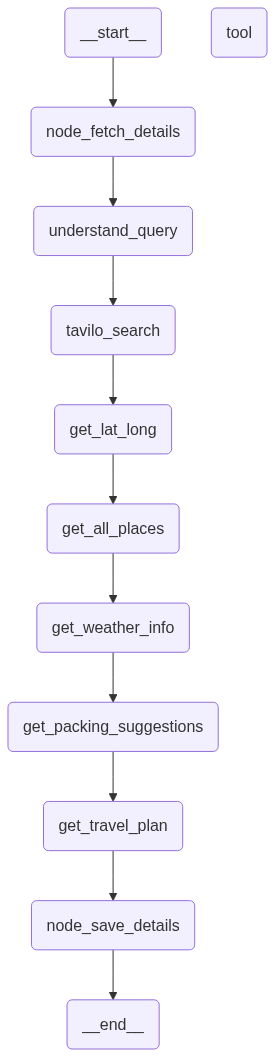

In [0]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png(max_retries=5)))
except Exception as e:
  print(type(e).__name__)
  print(e)
  pass

### Code to run the agent

In [0]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except Exception as e:
        print(type(e).__name__)
        print(e)
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        # stream_graph_updates(user_input)
        break

User:  I am going to London, then Tokyo.

Enter your user_name:  hello123

Assistant: I am going to London, then Tokyo.
Assistant: ```json
{
  "destinations": [
    {
      "destination_name": "London",
      "destination_duration": "3"
    },
    {
      "destination_name": "Tokyo",
      "destination_duration": "3"
    }
  ],
  "interests": [],
  "total_duration": "6",
  "budget_tier": "3",
  "start_date": "2025-05-24",
  "end_date": "2025-05-29",
  "month_of_visit": "May",
  "purpose": "Moderate"
}
```
Assistant: It looks like you're planning a trip to London and Tokyo! While you're preparing, let me know if you need any specific information about these cities, such as attractions, transportation, local cuisine, or anything else. Enjoy your travels!
Assistant: It looks like you're planning a trip to London and Tokyo! While you're preparing, let me know if you need any specific information about these cities, such as attractions, transportation, local cuisine, or anything else. Enjoy your travels!
Assistant: It looks like you're planning a trip to London an

User:  

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:729)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:447)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:447)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio